In [1]:
%load_ext autoreload
%autoreload 2

import math

import geopandas as gpd
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import pyart
from scipy.interpolate import interp2d
from scipy.interpolate import bisplrep
from scipy.interpolate import griddata
import pyart_utils


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload

## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



### 09-01 (quiet time)

In [3]:
res, radar = pyart_utils.load_filter_dbzh('data/2017-09/01/KOKX20170901_000243_V06.ar2v',return_radar=True)
radar_df = pyart_utils.gen_radar_df(radar)

In [4]:
radar_df["dbzh_imputed"] = radar_df["dbzh"].fillna(0)
hscan_df = radar_df[radar_df["sweep"] == 0]
hscan_initial_cut = hscan_df[(hscan_df['lat'] >= 40.45 ) & (hscan_df['lat'] <= 40.95) &
        (hscan_df['lon'] >= -74.15) & (hscan_df['lon'] <= -73.75)]

hscan_lower_manhattan = hscan_df[(hscan_df['lat'] >= 40.696417 ) & (hscan_df['lat'] <= 40.766791) &
        (hscan_df['lon'] >= -74.022494) & (hscan_df['lon'] <= -73.959454)]


In [5]:
mn = gpd.read_file("data/pluto/MNMapPLUTO.shp").to_crs(epsg=4326)

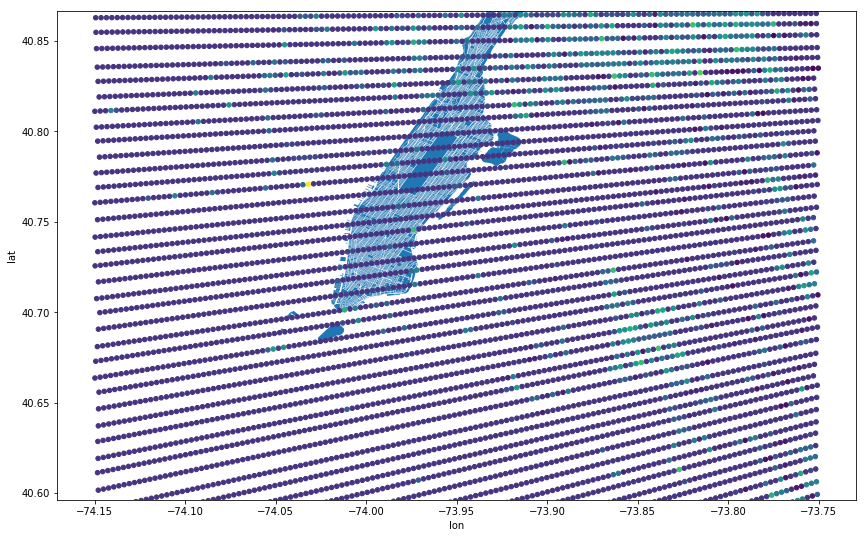

In [6]:
ax = mn.plot(figsize=(16, 9))
min_lat = 40.596417
max_lat = 40.866791
ax.set_ylim([min_lat, max_lat])
hscan_initial_cut.plot('lon', 'lat', c='dbzh_imputed', kind='scatter',  cmap='viridis', ax=ax, colorbar=False)


In [7]:
lat_min, lat_max = hscan_lower_manhattan.y.min(), hscan_lower_manhattan.y.max()
lon_min, lon_max = hscan_lower_manhattan.x.min(), hscan_lower_manhattan.x.max()

scales = [100, 200, 500]
results = []
for scale in scales:
    x = np.linspace(lon_min, lon_max, math.floor((lon_max - lon_min) / scale))
    y = np.linspace(lat_min, lat_max, math.floor((lat_max - lat_min) / scale))
    xx, yy = np.meshgrid(x, y)
    result = griddata((hscan_initial_cut["x"], hscan_initial_cut["y"]),
                      hscan_initial_cut["dbzh_imputed"],
                      (xx, yy))
    results.append((xx, yy, result))

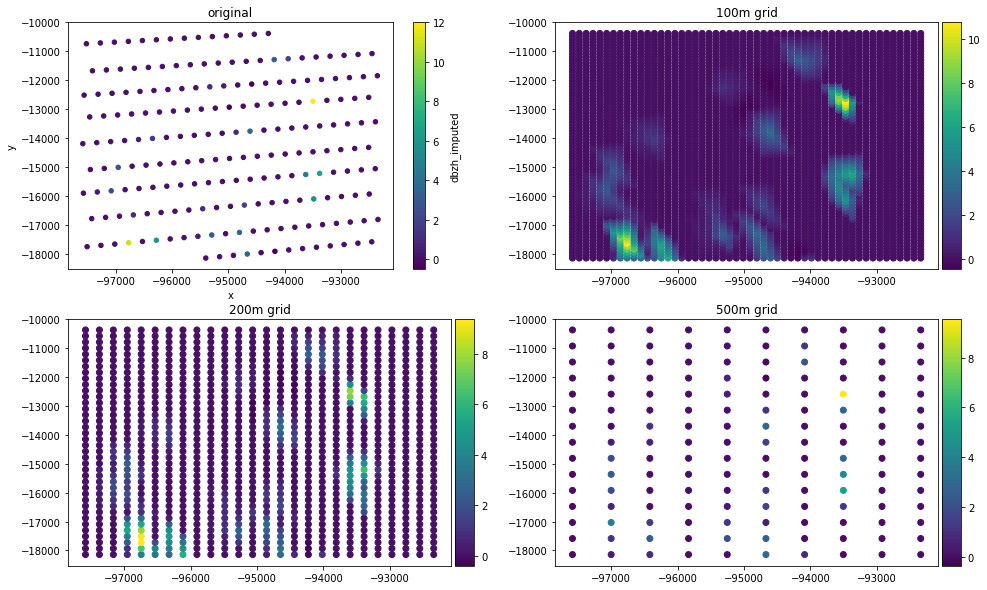

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(16,10))
ax1, ax2, ax3, ax4 = axes.flatten()
hscan_lower_manhattan.plot("x", "y", c="dbzh_imputed", 
                           kind='scatter', ax=ax1, cmap='viridis', sharex=False)
ax1.set_title("original")
for ax, scale, (xx, yy, result) in zip((ax2, ax3, ax4), scales, results):
    scatter = ax.scatter(xx.reshape(-1), yy.reshape(-1), c=result.reshape(-1))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)

    fig.colorbar(scatter, cax=cax)
    ax.set_title("{}m grid".format(scale))

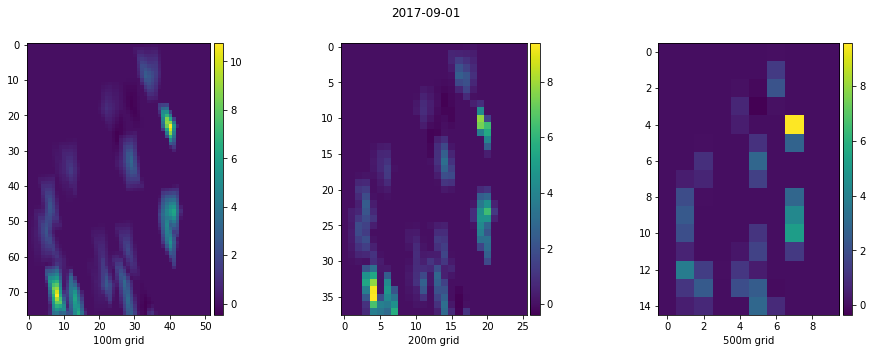

In [30]:
fig, axes = plt.subplots(1, 3, figsize=(16,5))
axes = axes.flatten()
for ax, scale, (xx, yy, result) in zip(axes, scales, results):
    im = ax.imshow(np.rot90(np.transpose((result))))
    ax.set_xlabel("{}m grid".format(scale))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)

    fig.colorbar(im, cax=cax)
    fig.suptitle("2017-09-01")

### Test util functions

In [76]:
pyart_utils.AR2V_FILE

'data/09/01/KOKX20170901_000243_V06.ar2v'

In [140]:
result = pyart_utils.load_filter_dbzh("data/2017-09/28/KOKX20170928_000426_V06.ar2v")
result

RadarResult(dbzh=masked_array(
  data=[[-6.5, -6.0, -6.0, ..., --, --, --],
        [-9.0, -7.0, -5.0, ..., --, --, --],
        [-3.5, -2.0, -0.5, ..., --, --, --],
        ...,
        [-0.5, --, -4.0, ..., --, --, --],
        [-12.0, 8.0, -4.5, ..., --, --, --],
        [-5.0, --, -0.5, ..., --, --, --]],
  mask=[[False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        ...,
        [False,  True, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        [False,  True, False, ...,  True,  True,  True]],
  fill_value=0.0,
  dtype=float32), x=array([[  -1534.81280566,   -1715.37871727,   -1895.94445254, ...,
        -331312.36499116, -331492.26133485, -331672.06739178],
       [  -1547.64524125,   -1729.72084866,   -1911.79627825, ...,
        -334082.4386902 , -334263.83913148, -334445.14853113],
       [  -1561.32624988,   -1745.0

(40.68, 40.77)

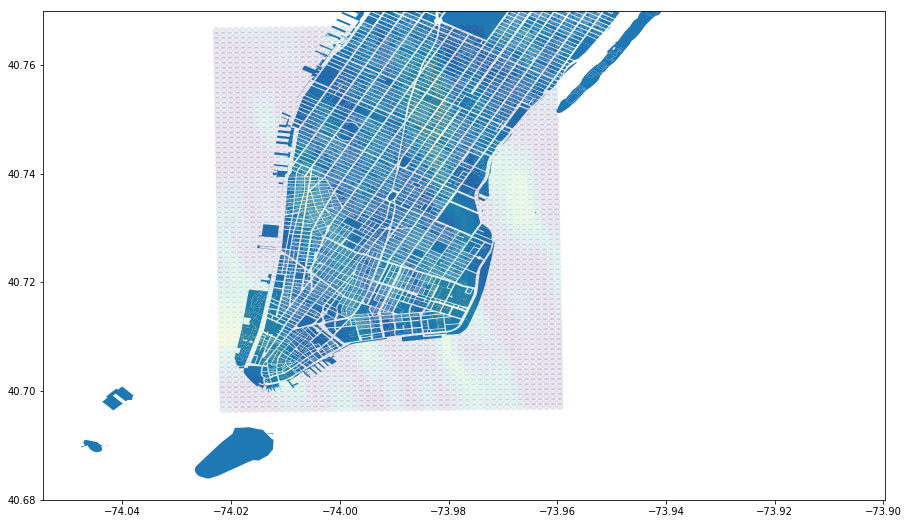

In [141]:
interp = pyart_utils.interp_radar_values(result,
                                pyart_utils.MN_INIT_CUT, pyart_utils.LOWER_MN)

res, trans, xx, yy = interp

ax = mn.plot(figsize=(16, 9))

ax.scatter(trans[0].reshape(-1), trans[1].reshape(-1), c=res.reshape(-1), alpha=.1)
ax.set_ylim([40.68, 40.77])

In [132]:
trans

(array([[-74.02141193, -74.02019359, -74.01897524, ..., -73.96171254,
         -73.96049418, -73.95927581],
        [-74.02142789, -74.02020953, -74.01899117, ..., -73.96172768,
         -73.96050929, -73.95929091],
        [-74.02144385, -74.02022547, -74.01900709, ..., -73.96174281,
         -73.96052441, -73.95930601],
        ...,
        [-74.02259451, -74.02137492, -74.02015534, ..., -73.96283415,
         -73.96161454, -73.96039493],
        [-74.02261052, -74.02139091, -74.02017131, ..., -73.96284933,
         -73.9616297 , -73.96041008],
        [-74.02262652, -74.0214069 , -74.02018728, ..., -73.96286451,
         -73.96164487, -73.96042522]]),
 array([[40.69659316, 40.69660535, 40.69661753, ..., 40.69717538,
         40.69718694, 40.69719849],
        [40.69751045, 40.69752264, 40.69753482, ..., 40.69809268,
         40.69810424, 40.69811579],
        [40.69842774, 40.69843993, 40.69845211, ..., 40.69900998,
         40.69902155, 40.69903309],
        ...,
        [40.764472

## 09-27 at midnight, many birds

In [31]:
res, radar = pyart_utils.load_filter_dbzh('data/2017-09/28/KOKX20170928_000426_V06.ar2v',return_radar=True)
radar_df = pyart_utils.gen_radar_df(radar)

In [32]:
radar_df["dbzh_imputed"] = radar_df["dbzh"].fillna(0)
hscan_df = radar_df[radar_df["sweep"] == 0]
hscan_initial_cut = hscan_df[(hscan_df['lat'] >= 40.45 ) & (hscan_df['lat'] <= 40.95) &
        (hscan_df['lon'] >= -74.15) & (hscan_df['lon'] <= -73.75)]

hscan_lower_manhattan = hscan_df[(hscan_df['lat'] >= 40.696417 ) & (hscan_df['lat'] <= 40.766791) &
        (hscan_df['lon'] >= -74.022494) & (hscan_df['lon'] <= -73.959454)]


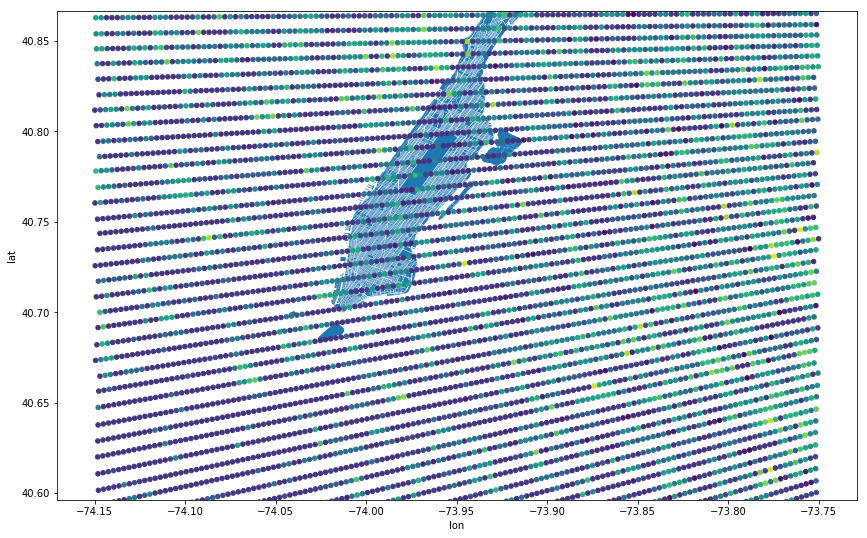

In [33]:
ax = mn.plot(figsize=(16, 9))
min_lat = 40.596417
max_lat = 40.866791
ax.set_ylim([min_lat, max_lat])
hscan_initial_cut.plot('lon', 'lat', c='dbzh_imputed', kind='scatter',  cmap='viridis', ax=ax, colorbar=False)


In [34]:
lat_min, lat_max = hscan_lower_manhattan.y.min(), hscan_lower_manhattan.y.max()
lon_min, lon_max = hscan_lower_manhattan.x.min(), hscan_lower_manhattan.x.max()

scales = [100, 200, 500]
results = []
for scale in scales:
    x = np.linspace(lon_min, lon_max, math.floor((lon_max - lon_min) / scale))
    y = np.linspace(lat_min, lat_max, math.floor((lat_max - lat_min) / scale))
    xx, yy = np.meshgrid(x, y)
    result = griddata((hscan_initial_cut["x"], hscan_initial_cut["y"]),
                      hscan_initial_cut["dbzh_imputed"],
                      (xx, yy))
    results.append((xx, yy, result))

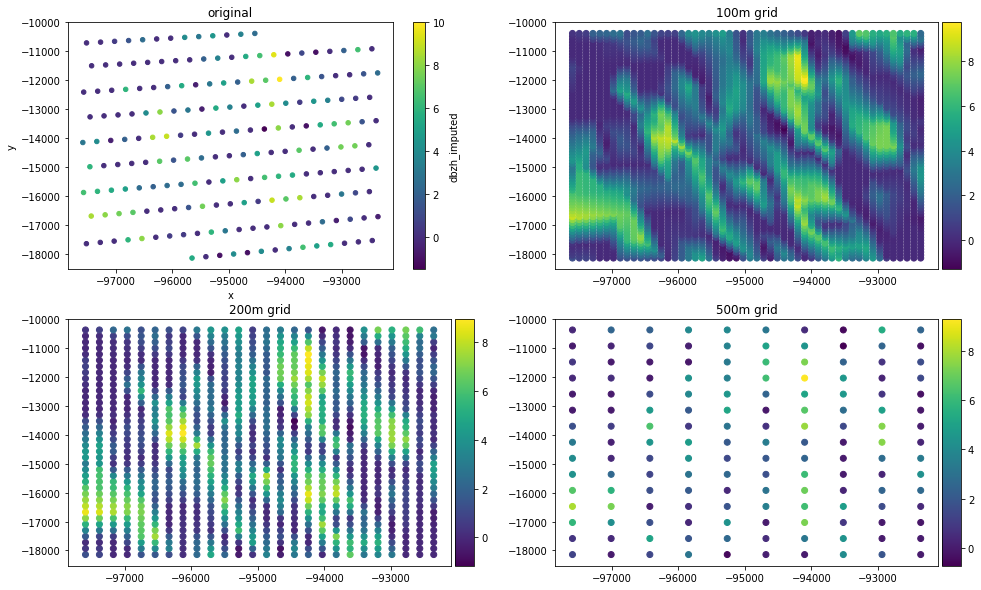

In [35]:
fig, axes = plt.subplots(2, 2, figsize=(16,10))
ax1, ax2, ax3, ax4 = axes.flatten()
hscan_lower_manhattan.plot("x", "y", c="dbzh_imputed", 
                           kind='scatter', ax=ax1, cmap='viridis', sharex=False)
ax1.set_title("original")
for ax, scale, (xx, yy, result) in zip((ax2, ax3, ax4), scales, results):
    scatter = ax.scatter(xx.reshape(-1), yy.reshape(-1), c=result.reshape(-1))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)

    fig.colorbar(scatter, cax=cax)
    ax.set_title("{}m grid".format(scale))

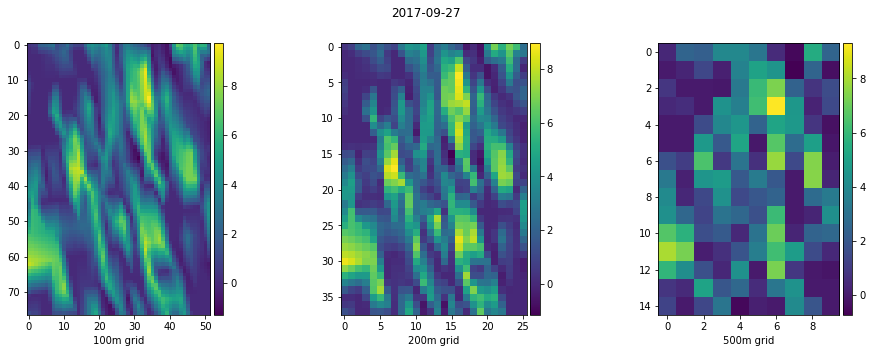

In [37]:
fig, axes = plt.subplots(1, 3, figsize=(16,5))
axes = axes.flatten()
for ax, scale, (xx, yy, result) in zip(axes, scales, results):
    im = ax.imshow(np.rot90(np.transpose((result))))
    ax.set_xlabel("{}m grid".format(scale))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)

    fig.colorbar(im, cax=cax)
    fig.suptitle("2017-09-27")